## Network analysis

### 1. Data preprocessing and visualization

In [1]:
import pandas as pd

# Import the data
application_events = pd.read_json('D:\\events\\applications.json')

# Print overview
application_events.head(3)

,appIdConsumer,appIdProvider,beatId,beatType,callId,callMode,callScope,correlationId,durationMs,eventTime,...,orgBezeichnung,orgId,orgKurzbezeichnung,orgSubkategorien,parentCallId,role,stage,tkNameIdConsumer,tkNameIdProvider,userId
0,spoud-app,sim-provider,0,ServiceProviderBeat,0,SYNC,LOCAL,6ee2fa2b-a1ca-405e-9088-94dbb834730f,201,2018-05-05T07:55:38.422185+00:00,...,Bellinzona,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU147400
1,spoud-app,sim-provider,2,ServiceProviderBeat,2,SYNC,LOCAL,7aa2e01f-4af6-48e8-ae98-a42fe9fc6e5d,201,2018-05-05T07:55:38.432086+00:00,...,Lyss,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU534284
2,spoud-app,sim-provider,4,ServiceProviderBeat,4,SYNC,LOCAL,f722a638-7e0d-4f19-86ad-7aeecbffa40f,201,2018-05-05T07:55:38.441987+00:00,...,Winterthur,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU816207


In [2]:
# Print some initial statistics
application_events.describe()

,beatId,callId,durationMs,meta_linecount,meta_version
count,1.296000e+06,1.296000e+06,1.296000e+06,1296000.0,1.296000e+06
mean,1.799000e+03,1.169906e+02,3.598675e+02,1.0,1.000000e-01
std,1.039231e+03,8.128626e+01,1.350601e+02,0.0,2.357893e-12
min,0.000000e+00,0.000000e+00,2.000000e+02,1.0,1.000000e-01
25%,8.995000e+02,4.950000e+01,2.690000e+02,1.0,1.000000e-01
50%,1.799000e+03,1.020000e+02,3.400000e+02,1.0,1.000000e-01
75%,2.698500e+03,1.760000e+02,4.250000e+02,1.0,1.000000e-01
max,3.598000e+03,3.180000e+02,1.955000e+03,1.0,1.000000e-01


In [135]:
# Check for missing values
null_values = application_events.isnull().sum()
print('Number of None/NaN\'s: %s' % null_values[null_values != 0].count())

Number of None/NaN's: 0


##### Worktime calculation

$$\large w_t = \bar{r}_n * n_c $$

($ w_t $ = worktime,
$ r_t $ = response time,
$ n_c $ = throughput / number of service calls)


In [4]:
# Overview of involved components
tk_field, event_time_field, duration_field = 'tkNameIdProvider', 'eventTime', 'durationMs'
id_fields = ['appIdProvider', 'fkNameProvider', tk_field]
unique_components = zip([id_field for id_field in id_fields], 
                        ['Application', 'Functional component', 'Technical component'])
for field, name in unique_components:
    unique_components = application_events[field].unique()
    print('%d %s\'s:' % (unique_components.size, name), end=' ')
    print(', '.join(str(c) for c in unique_components))

1 Application's: sim-provider
1 Functional component's: fkNameProvider
18 Technical component's: tm4-Mond-52, tm4-Phobos-52, tm4-Deimos-52, tm4-Adrastea-52, tm4-Metis-52, tm4-Amalthea-52, tm4-Thebe-52, tm4-Io-52, tm4-Europa-52, tm4-Ganymed-52, tm4-Kallisto-52, tm4-Themisto-52, tm4-Leda-52, tm4-Himalaia-52, tm4-Lysithea-52, tm4-Elara-52, tm4-Carpo-52, tm4-Euporie-52


In [5]:
# Create dataset with one minute buckets and only relevant information
performance = application_events[[tk_field, duration_field, event_time_field]]
performance = performance.set_index(event_time_field)
performance.index = pd.to_datetime(performance.index)

In [117]:
# Inspect time frame
times = performance.index.min(), performance.index.max(), performance.index.max() - performance.index.min(), 
print('Time frame: %s to %s (%s)' % (start.strftime("%Y-%m-%d %H:%M:%S"), end.strftime("%Y-%m-%d %H:%M:%S"), duration))

Time frame: 2018-05-05 07:55:38 to 2018-05-05 19:54:39 (0 days 11:59:00.993711)


In [7]:
# Group the data into one minutes bin grouped by technical component
#performance_bins = performance.groupby(tk_field).resample('1T').sum() \
#    .reset_index() \
#    .pivot(index='eventTime', columns='tkNameIdProvider', values='durationMs')

In [8]:
# Build a dicitionary with all components
all_components = {}

# Method for building statistics for group
def aggregate_stats(group):
    number_of_requests = group_component.count()
    total_duration = group_component.sum()
    avg_response_time = total_duration / number_of_requests
    # (Inconsistend definition in document
    # worktime = avg_response_time * number_of_requests)
    performance_of_component = pd.DataFrame({'component_name': technical_component,  
                                             'worktime' : total_duration, 
                                             'throughput' : number_of_requests, 
                                             'response_time' : avg_response_time})
    return performance_of_component

for technical_component in performance[tk_field].unique():       
    group_component = performance.loc[performance[tk_field] == technical_component] \
        .resample('1T')[duration_field]
    all_components[technical_component] = aggregate_stats(group_component)

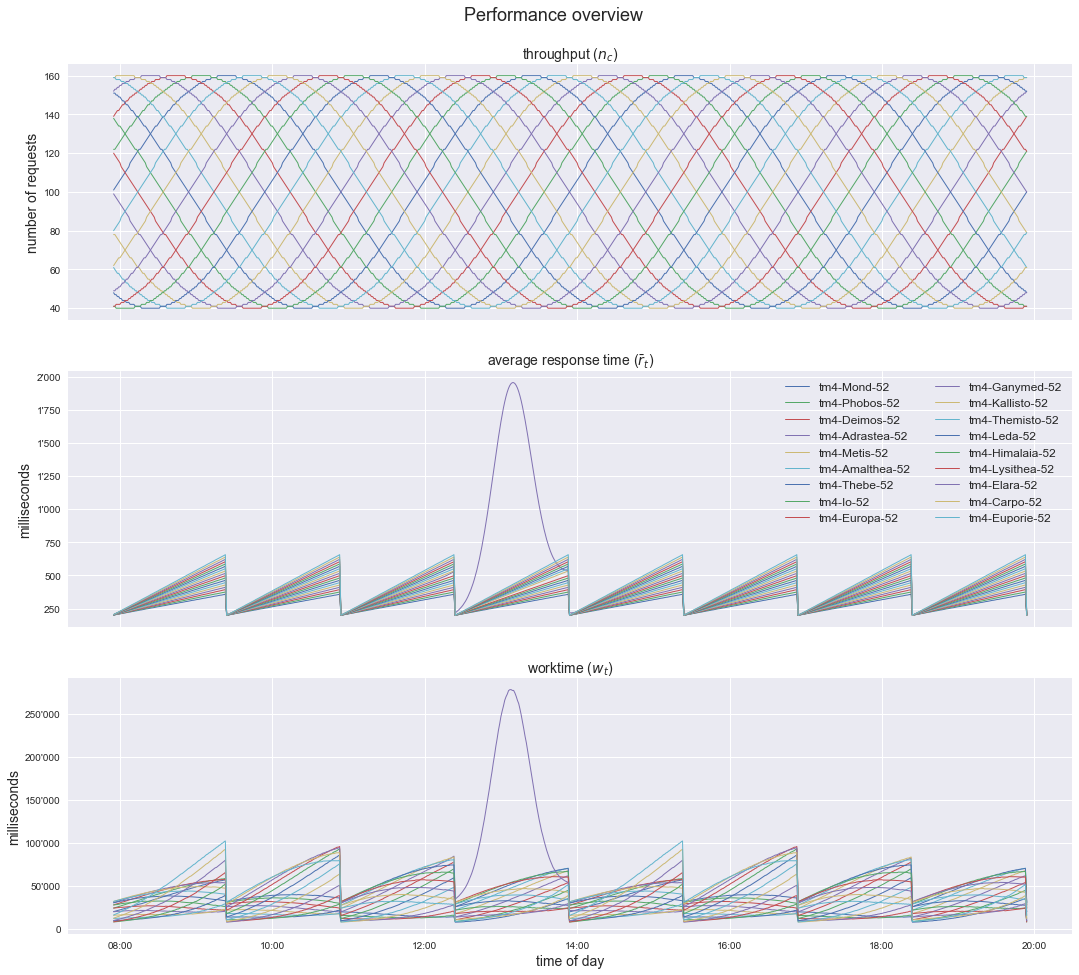

In [83]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale
import numpy as np

# Set searborn style for plot
plt.style.use('seaborn')

# Plot metrics for comparision
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18,16))
plt.suptitle('Performance overview', fontsize=18, y=.93)
locale.setlocale(locale.LC_ALL, 'de-CH')
thousand_formatter = plt.FuncFormatter(lambda x, _ : locale.format("%d", x, grouping=True))
for component in all_components.values():
    
    ax1.plot(component['throughput'], linewidth=1)
    ax1.set_title('throughput ($ n_c $)', fontsize=14)
    ax1.set_ylabel('number of requests', fontsize=14)
    
    ax2.plot(component['response_time'], linewidth=1)
    ax2.set_title('average response time ($ \\bar{r}_t $)', fontsize=14)
    ax2.yaxis.set_major_formatter(thousand_formatter)
    ax2.set_ylabel('milliseconds', fontsize=14)
    
    ax3.plot(component['worktime'], linewidth=1)
    ax3.set_title('worktime ($ w_t $)', fontsize=14)
    ax3.set_ylabel('milliseconds', fontsize=14)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))    
    ax3.yaxis.set_major_formatter(thousand_formatter)
    ax3.set_xlabel('time of day', fontsize=14)

ax2.legend(all_components.keys(), ncol=2, prop={'size': 12})
plt.show()

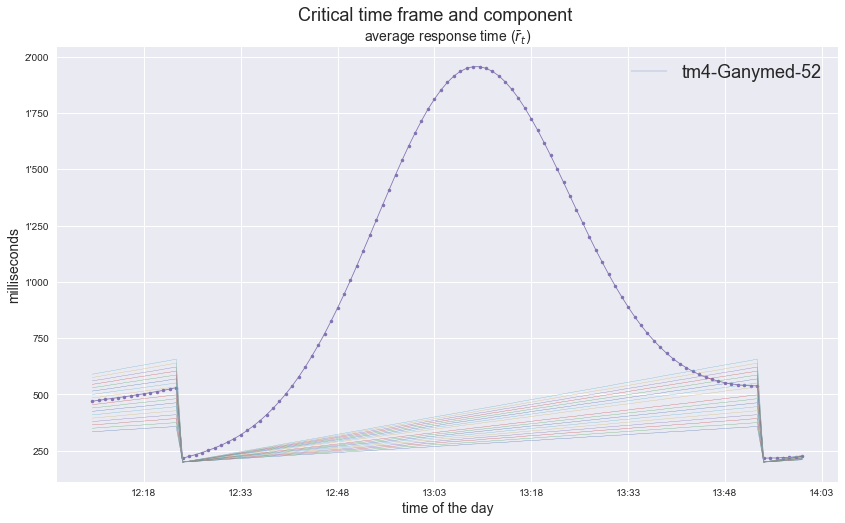

In [118]:
# Have a closer look at the critical time
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(14,8))
plt.suptitle('Critical time frame and component', fontsize=18, y=.95)
for name, component in all_components.items():
    
    ax.plot(component['2018-05-05 12:10:00':'2018-05-05 14:00:00']['response_time'], 
            '.-' if name == 'tm4-Ganymed-52' else '-',
            linewidth=.8 if name == 'tm4-Ganymed-52' else .3)
    ax.set_title('average response time ($ \\bar{r}_t $)', fontsize=14)
    ax.yaxis.set_major_formatter(thousand_formatter)
    ax.set_ylabel('milliseconds', fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))    
    ax.yaxis.set_major_formatter(thousand_formatter)
    ax.set_xlabel('time of the day', fontsize=14)

ax.legend(['tm4-Ganymed-52'], ncol=2, prop={'size': 18})
plt.show()

### 2. Time series forecasting

In [31]:
# Choose component for forecasting
chosen_component = all_components['tm4-Himalaia-52']
chosen_component.head()

,component_name,response_time,throughput,worktime
eventTime,,,,
2018-05-05 07:55:00,tm4-Himalaia-52,204.0,41,8364
2018-05-05 07:56:00,tm4-Himalaia-52,208.0,41,8528
2018-05-05 07:57:00,tm4-Himalaia-52,213.0,40,8520
2018-05-05 07:58:00,tm4-Himalaia-52,217.0,40,8680
2018-05-05 07:59:00,tm4-Himalaia-52,221.0,40,8840


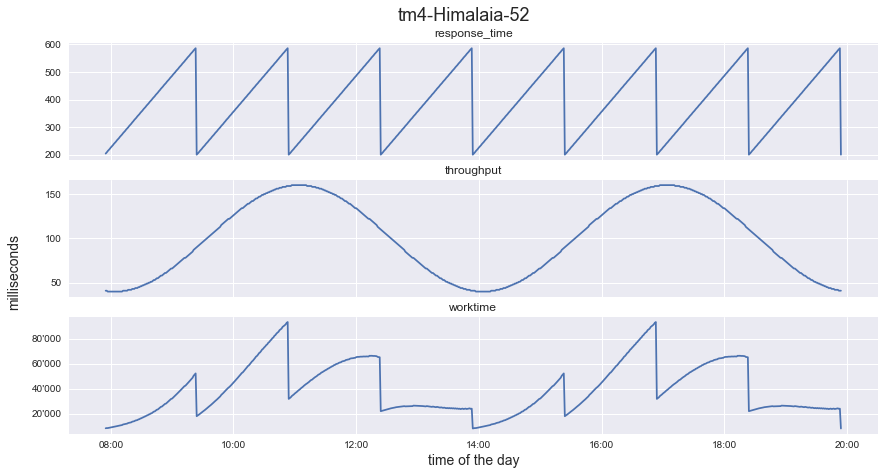

In [132]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 6))

plt.tight_layout()
plt.suptitle('tm4-Himalaia-52', fontsize=18, y=1.05)
for axis, feature in zip(axes, ['response_time', 'throughput', 'worktime']):
    axis.plot(chosen_component[feature]) 
    axis.set_title(feature)
    axis.yaxis.set_major_formatter(thousand_formatter)
    
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))    
axes[2].set_xlabel('time of the day', fontsize=14)
fig.text(-.02, .5, 'milliseconds', ha='center', rotation='vertical', fontsize=14)
plt.show()

Because there is a linear increase in respone time a multiplicative model for decomposition has been chosen. 

### 2.1 Average response time

#### 2.1.1 Seasonal decomposition of average response time

In [632]:
def plot_correlation(data):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
    plot_acf(data, alpha=.05, lags=(2*60), ax=ax1)
    plot_pacf(data, alpha=.05, lags=(2*60), ax=ax2)
    plt.show()
    print('Autocorrelation is: %4.2f' % data.autocorr())

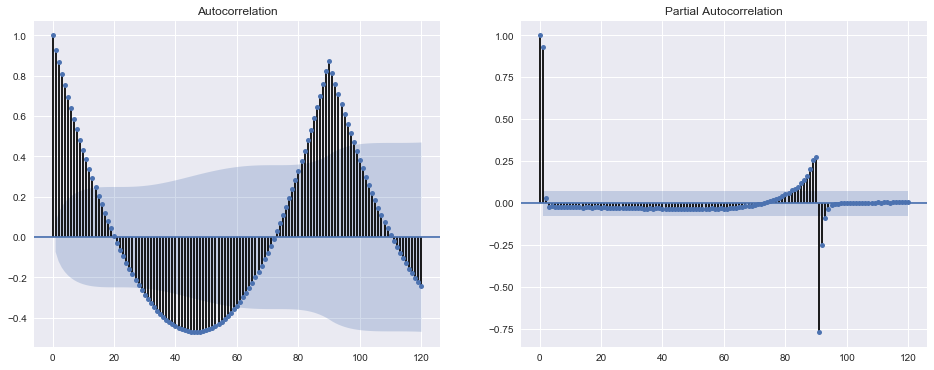

Autocorrelation is: 0.93


In [633]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

response_times = chosen_component['response_time']

# Examine autocorrelation and partial autocorrelation of the response times
plot_correlation(response_times)

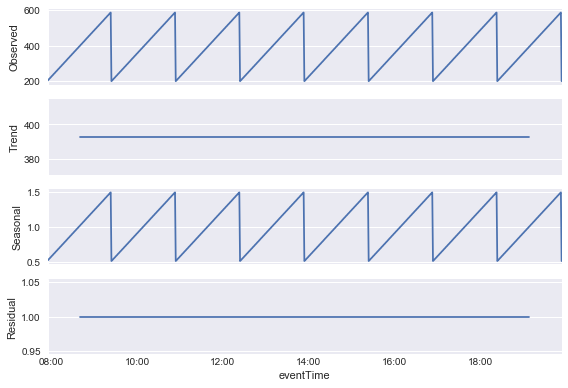

In [248]:
import statsmodels.api as sm

# Plot the decomposition of the time series
response_time_components = sm.tsa.seasonal_decompose(chosen_component['response_time'], model='multiplicative', freq=90)
response_time_components.plot()
plt.show()

There is only seasonality and no trend and noise in the (obviously artifically created) data.

#### 2.1.2 Generating a forecast for response time

Straightforward would be to learn paramaters for an ARMA (auto regressive moving average) model

In [662]:
from datetime import timedelta 

# Because the data is artifical we choose 60/40 split 
def train_test_split(data):
    split_minute = data.index[0] + timedelta(minutes=(12 * 60) * .6)
    train_data = data[:split_minute]
    test_data = data.iloc[train_data.count():]
    print("Training data: %s rows" % train_data.count())
    print("Testing data: %s rows" % test_data.count())
    return (train_data, test_data)

In [663]:
train_data, test_data = train_test_split(response_times)

Training data: 433 rows
Testing data: 287 rows


In [682]:
import itertools
import warnings

def sarimax_grid_search(data, plot_progress = False):
    
    # Because not all parameter of a grid search work, we disable warnings
    warnings.filterwarnings('ignore')

    max_param = 2
    p=d=q = range(0, max_param)

    bic = {}
    aic = {}

    # Initialize cartesian product for non seasonal parameters
    pdq = list(itertools.product(p, d, q))

    # and for seasonal parameters (with fix lag for seasonality)
    seasonal_pdq = [(x[0], x[1], x[2], 90) for x in list(itertools.product(p, d, q))]

    # Performing a grid search over the different parameters evaluate their information criterias
    for model in pdq:
        for seasonal_model in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=model,
                                                seasonal_order=seasonal_model,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                result = mod.fit()
                if plot_progress:
                    print('SARIMAX %sx%s' % (str(model), (seasonal_model)), end=' ')
                    print('-- AKAIKE: %s, BIC: %s' % (result.aic, result.bic))
                key = '%sx%s' % (str(model), (seasonal_model))
                bic[key] = result.bic
                aic[key] = result.aic
            except:
                continue
                
    warnings.filterwarnings('default')
    
    best_model = min(aic, key=aic.get)
    return (bic, aic, best_model)

In [ ]:
bic, aic, best_model = sarimax_grid_search(train_data)

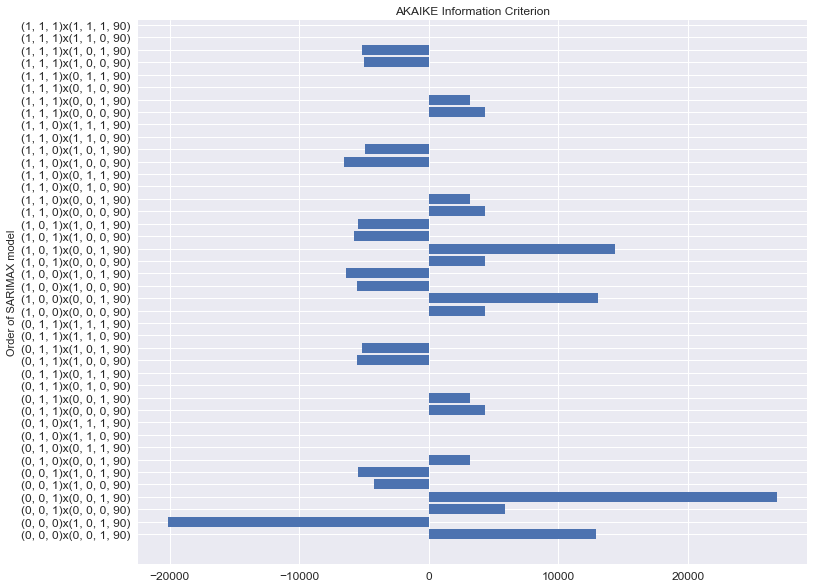

In [614]:
# Print different models with their akaike information criterions
fit, ax1 = plt.subplots(1, sharex=True, figsize=(12,10))

ax1.tick_params(labelsize=12)
ax1.barh(range(len(aic.keys())), aic.values(), 
        tick_label=aic.keys())
ax1.set_title('AKAIKE Information Criterion')
ax1.set_ylabel('Order of SARIMAX model')

plt.show()

In [575]:
# Print performance of model with lowest information criteria
print("Performance Model %s: %s (BIC) / %s (AKAIKE)" % (best_model,
      bic[best_model], aic[best_model]))

Performance Model (0, 0, 0)x(1, 0, 1, 90): -20125.0015676 (BIC) / -20137.2137808 (AKAIKE)


The best model is a SARIMAX (Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors) of order (0, 0, 0)x(1, 0, 1, 90). This makes sense, because there are no residuals in our model and it can be explained by the seasonal components only

In [622]:
warnings.filterwarnings('ignore')

results = None

# We fit the model with our parameters from the grid search
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=(0, 0, 0),
                                seasonal_order=(1, 0, 1, 90),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

warnings.filterwarnings('default')

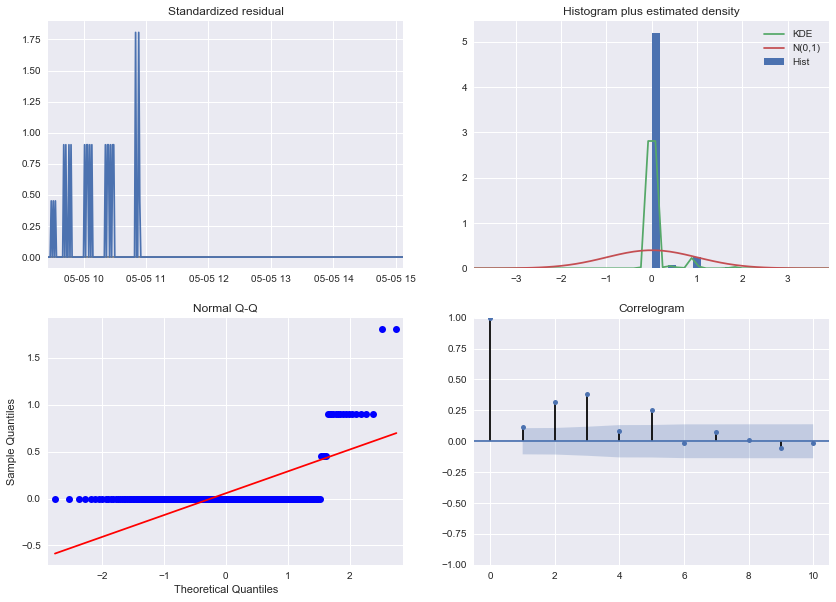

In [621]:
# Print some diagnostics for the residuals (not of much help, because we lack residuals)
results.plot_diagnostics(figsize=(14, 10))

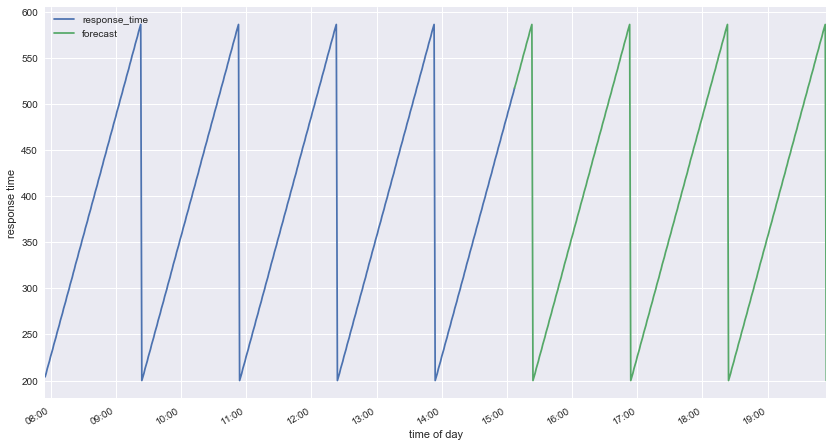

In [616]:
# Performing a one step ahead forecast
pred = results.get_prediction(start='2018-05-05 15:07:00', end='2018-05-05 19:54:00', dynamic=False)
conf_int = pred.conf_int()

fig, ax = plt.subplots(1, 1, figsize=(14,8))

ax.plot(train_data)
pred.predicted_mean.plot(ax=ax, label='forecast')
ax.set_ylabel('response time')
ax.set_xlabel('time of day')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.legend()
plt.show()

In [500]:
def calculate_mse(actual, predicted):
    mse = ((actual - predicted) ** 2).mean()
    print('The MSE of our forecast is %s' % mse)

In [617]:
# Calculate the mean squred error of our predition
calculate_mse(pred.predicted_mean, test_data)

The MSE of our forecast is 0.0


### 2.2 Throughput (number of requests)

#### 2.2.1 Seasonal decomposition of throughput

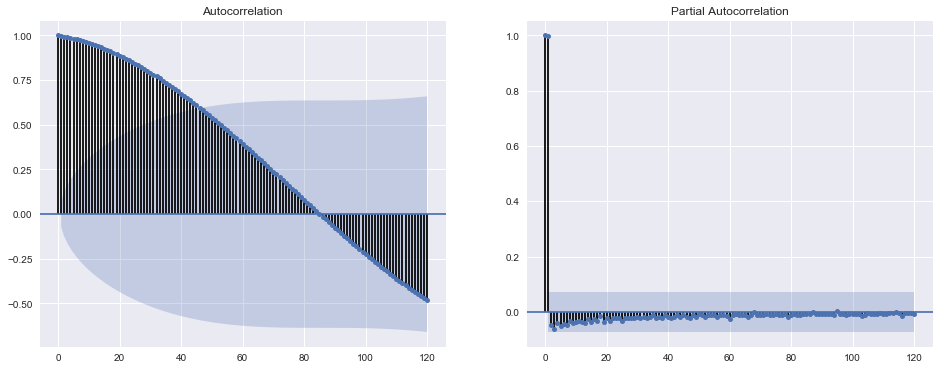

Autocorrelation is: 1.00


In [635]:
throughput = chosen_component['throughput']

# Examine autocorrelation and partial autocorrelation of the throughput
plot_correlation(throughput)

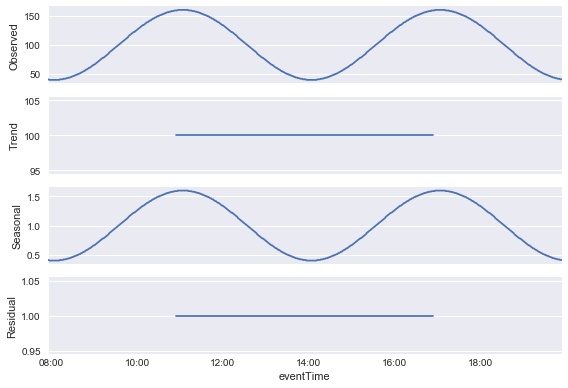

In [664]:
# Plot the decomposition of the throughput
throughput_components = sm.tsa.seasonal_decompose(throughput, model='multiplicative', freq=360)
throughput_components.plot()
plt.show()

Same as above, there is only a seasonal variation in the data

#### 2.2.2 Forecast of throughput

In [665]:
# Performing split for throughput
train_data, test_data = train_test_split(throughput)

Training data: 433 rows
Testing data: 287 rows


In [ ]:
# Grid search over parameters for sarimax model
bic, aic, best_model = sarimax_grid_search(train_data)

In [ ]:
# fit model

In [ ]:
# plot model

### 2.3 Worktime

#### 2.3.1 Seasonal decomposition of worktime

In [ ]:
worktime = chosen_component['worktime']

# Examine autocorrelation and partial autocorrelation of the worktime
plot_correlation(worktime)

In [ ]:
# Plot the decomposition of the throughput
worktime_components = sm.tsa.seasonal_decompose(worktime, model='multiplicative', freq=360)
worktime_components.plot()
plt.show()

In [ ]:
# fit model

In [ ]:
# plot model

#### 2.3.2 Forecast of worktime

In [ ]:
# Performing split for throughput
train_data, test_data = train_test_split(worktime)

In [ ]:
# Grid search over parameters for sarimax model
bic, aic, best_model = sarimax_grid_search(train_data)

### 3. Correlating the layers